In [42]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import cv2
import requests
import urllib
import string

## Iris Dataset

In [2]:
iris = pd.read_csv("dataset/iris.csv")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
inputs = iris.values[:, :4]
outputs = iris.values[:, 4]

print("Idx\t Inputs\t\t\t Output")
print("===\t ======\t\t\t ======")

for i in rnd.sample(range(len(iris) + 1), 10):
    print(i, "\t", inputs[i], "\t", outputs[i])

Idx	 Inputs			 Output
===	 ======			 ======
79 	 [5.7 2.6 3.5 1.0] 	 versicolor
23 	 [5.1 3.3 1.7 0.5] 	 setosa
10 	 [5.4 3.7 1.5 0.2] 	 setosa
7 	 [5.0 3.4 1.5 0.2] 	 setosa
43 	 [5.0 3.5 1.6 0.6] 	 setosa
139 	 [6.9 3.1 5.4 2.1] 	 virginica
56 	 [6.3 3.3 4.7 1.6] 	 versicolor
69 	 [5.6 2.5 3.9 1.1] 	 versicolor
73 	 [6.1 2.8 4.7 1.2] 	 versicolor
24 	 [4.8 3.4 1.9 0.2] 	 setosa


## Visualizing Iris Dataset

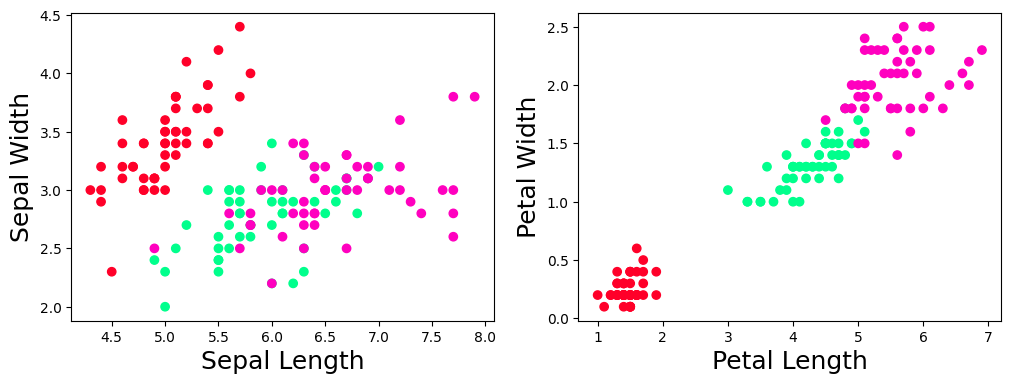

In [38]:
classes = ["setosa", "versicolor", "virginica"]
Y = [classes.index(output) for output in outputs if output in classes]

fig = plt.figure(figsize=(12, 4))
sepals = inputs[:, :2]
fig.add_subplot(1, 2, 1)
plt.scatter(sepals[:, 0], sepals[:, 1], c=Y, cmap="gist_rainbow")
plt.xlabel("Sepal Length", fontsize=18)
plt.ylabel("Sepal Width", fontsize=18)

petals = inputs[:, 2:]
fig.add_subplot(1, 2, 2)
plt.scatter(petals[:, 0], petals[:, 1], c=Y, cmap="gist_rainbow")
plt.xlabel("Petal Length", fontsize=18)
plt.ylabel("Petal Width", fontsize=18)

plt.show()

## K-means clustering using SSE as initial centroids

In [33]:
class KMeans:
    def __init__(self, k, tolerance=0.01, max_iter=100):
        self.k = k
        self.tolerance = tolerance
        self.max_iter = max_iter

        self.clusters = [0 for _ in range(k)]
        self.centroids = np.zeros(k)
        self.labels = []

    def sse(self, data):
        new_data = np.append(
            data, np.zeros(data.shape[0]).reshape(-1, 1), axis=1
        ).astype(float)
        centroids = np.zeros((self.k, data.shape[1]))

        for cluster_idx in range(1, self.k):
            wcss = np.zeros(cluster_idx)

            for i in range(cluster_idx):
                members = new_data[new_data[:, -1] == i]
                means = members.mean(axis=0)
                wcss[i] = np.linalg.norm(members - means, axis=1).sum()

            max_sse_idx = wcss.argmax()
            x_max_sse_idx = new_data[:, -1] == max_sse_idx
            x_max_sse = new_data[x_max_sse_idx]

            variances, means = x_max_sse.var(axis=0), x_max_sse.mean(axis=0)
            max_variance_idx = variances.argmax()
            max_variance_mean = means[max_variance_idx]

            min_mean = x_max_sse[:, max_variance_idx] <= max_variance_mean
            max_mean = x_max_sse[:, max_variance_idx] > max_variance_mean

            centroids[max_sse_idx] = x_max_sse[min_mean].mean(axis=0)[:-1]
            centroids[cluster_idx] = x_max_sse[max_mean].mean(axis=0)[:-1]

            new_data[
                (x_max_sse_idx) & (new_data[:, max_variance_idx] <= max_variance_mean),
                -1,
            ] = cluster_idx
            new_data[
                (x_max_sse_idx) & (new_data[:, max_variance_idx] > max_variance_mean),
                -1,
            ] = max_sse_idx

        return centroids

    def fit(self, data):
        x_values = (
            data.astype(float)
            if isinstance(data, np.ndarray)
            else np.array(x_values).astype(float)
        )

        rows = x_values.shape[0]
        x_labels = np.zeros(rows)

        self.centroids = self.sse(x_values)
        for _ in range(self.max_iter):
            previous_centroids = np.copy(self.centroids)
            distances = np.column_stack(
                [
                    np.linalg.norm(x_values - centroid, axis=1)
                    for centroid in self.centroids
                ]
            )

            x_labels = distances.argmin(axis=1)
            self.centroids = np.array(
                [
                    centroid.mean(axis=0) if len(centroid) else centroid
                    for centroid in [
                        x_values[x_labels == centroid_idx]
                        for centroid_idx, _ in enumerate(self.centroids)
                    ]
                ]
            ).transpose(0, 1)

            if np.all(np.abs(self.centroids - previous_centroids) < self.tolerance):
                break

        x_values_with_labels = np.append(x_values, x_labels.reshape(-1, 1), axis=1)

        self.clusters = [
            np.array(x_values_with_labels[x_values_with_labels[:, -1] == centroid_idx])
            for centroid_idx in range(len(self.centroids))
        ]
        self.labels = x_values_with_labels[:, -1].astype(int)

## Testing with Iris Dataset

cluster_0:53 | cluster_1:47 | cluster_2:50

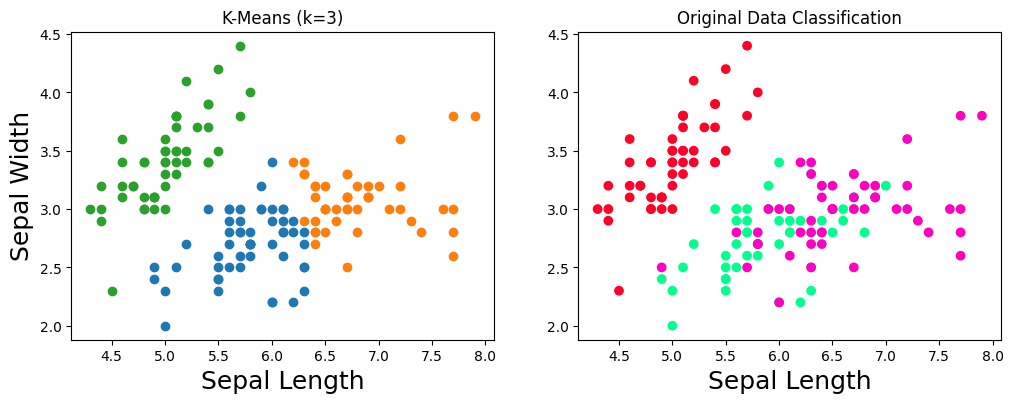

In [39]:
model = KMeans(k=3, tolerance=0.001, max_iter=500)
model.fit(inputs[:, :2])

for idx, i in enumerate(model.clusters):
    print(
        f"cluster_{idx}:{len(i)}{' | ' if idx != len(model.clusters)-1 else ''}", end=""
    )

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.title(f"K-Means (k={model.k})")
for i in range(len(model.clusters)):
    sepal = np.array(model.clusters[i])
    plt.scatter(sepal[:, 0], sepal[:, 1])
plt.xlabel("Sepal Length", fontsize=18)
plt.ylabel("Sepal Width", fontsize=18)

fig.add_subplot(1, 2, 2)
plt.title("Original Data Classification")
plt.scatter(sepals[:, 0], sepals[:, 1], c=Y, cmap="gist_rainbow")
plt.xlabel("Sepal Length", fontsize=18)

plt.show()


cluster_0:50 | cluster_1:54 | cluster_2:46

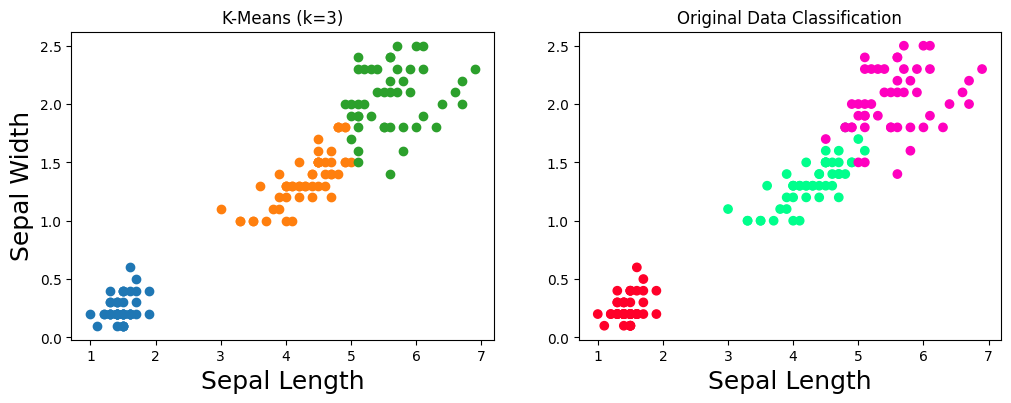

In [40]:
model = KMeans(k=3, tolerance=0.001, max_iter=500)
model.fit(inputs[:, 2:])

for idx, i in enumerate(model.clusters):
    print(
        f"cluster_{idx}:{len(i)}{' | ' if idx != len(model.clusters)-1 else ''}", end=""
    )

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.title(f"K-Means (k={model.k})")
for i in range(len(model.clusters)):
    sepal = np.array(model.clusters[i])
    plt.scatter(sepal[:, 0], sepal[:, 1])
plt.xlabel("Sepal Length", fontsize=18)
plt.ylabel("Sepal Width", fontsize=18)

fig.add_subplot(1, 2, 2)
plt.title("Original Data Classification")
plt.scatter(petals[:,0], petals[:,1], c=Y, cmap='gist_rainbow')
plt.xlabel("Sepal Length", fontsize=18)

plt.show()


## Download image from internet

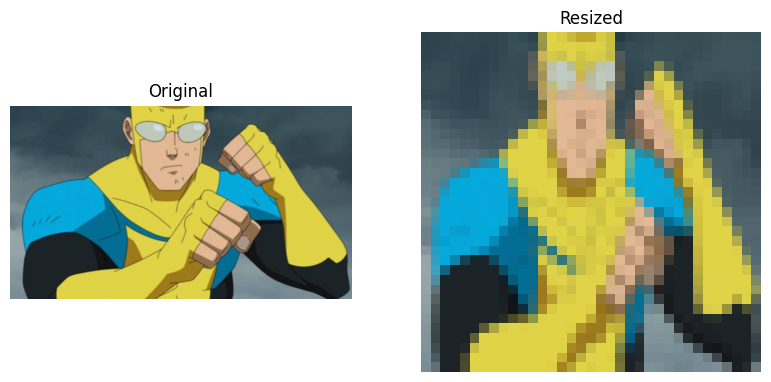

In [91]:
def download_image(url, dim = (50,50)):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(img)

    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    plt.subplot(3, 3, 2)
    plt.title("Resized")
    plt.axis('off')
    plt.imshow(img)

    return img

img = download_image("https://i.imgur.com/odBIEDB.png", (35, 35))

## K-means to compress an image

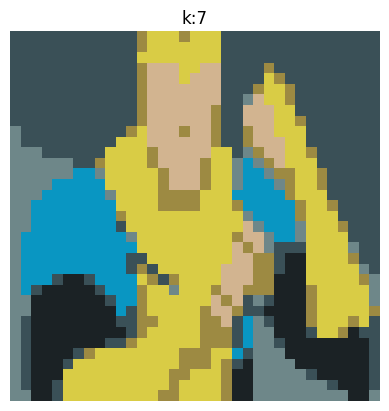

In [92]:
k = 7
height, width, channels = img.shape
img_array = np.reshape(np.array(img), (height * width, channels))

model = KMeans(k=k, max_iter=500, tolerance=0.001)
model.fit(img_array)

labels = np.reshape(model.labels, (height, width))
centers = model.centroids.astype(int)

reconstructed = [[centers[labels[i][j]] for j in range(width)] for i in range(height)]

plt.title(f"k:{k}")
plt.axis("off")
plt.imshow(reconstructed)

## Converting clusters to ascii

In [106]:
characters = list(string.printable[62:94])
np.random.shuffle(characters)

quantified = ["".join([characters[labels[i][j]] for j in range(width)]) for i in range(height)]
for i in quantified:
  print(i)

,,,,,,,,,,,,.""".""",,,,,,,,,,,,,,,
,,,,,,,,,,,,.""""""",,,,,,,,,,,,,,,
,,,,,,,,,,,,"""""""",,,,,,,,,,,,,,,
,,,,,,,,,,,,.:::""::,,,,.,,,,,,,,,,
,,,,,,,,,,,,.:::":::,,,,".,,,,,,,,,
,,,,,,,,,,,,.:::::::,,,."".,,,,,,,,
,,,,,,,,,,,,.:::::::,,]:"".,,,,,,,,
,,,,,,,,,,,,.::::::.,,:::"",,,,,,,,
,,,,,,,,,,,,.::::::.,,:::"".,,,,,,,
],,,,,,,,,,.":::.::.,,.::""",,,,,,,
],,,,,,,,,"""::::::.,,.:::"",,,,,,,
]]],,,,,,"""".:::::"",].::"".,,,,,,
]]]]]],,."""".::::.""]+].:""",,,,,,
]]]]]]++]""""".:::.""]++].."".,,,,,
]]]]+++++""""".:::.""]+++]."".,,,,,
]]]++++++]""""...."""+++++.""",,,,,
]]++++++++""""....""".+++++."".,,,,
]]++++++++."""""""""""]++++.""",,,,
]]++++++++,""""""""""":]+++]""".,,,
]++++++++++]""""""""".::]++]"""",,,
]+++++++++++""""""""":.:],,,""""],,
]++++++++++,,""""""""::..,--"""".,,
]++++++++++,.,"""""":::..,--"""""],
]+++,--,++++".,."""":::..---""""".]
]+,-----,+++.""]""".::...---."""""]
]]-------,++."""""":.:,],---."""""]
]]--------+,.""""".::.,,----.""""".
],--------,,..""""..:,+],---